**02 - Comparing Gesture Recognizers**

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM, Dropout

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

import time

import pandas as pd

NUM_POINTS = 50

Reading the training data

In [7]:
PATH_TRAIN = "dataset/xml_logs"
PATH_TEST = "dataset/test"

def read_dataset(path:str):
    data = []


    for root, subdirs, files in os.walk(path):
        if 'ipynb_checkpoint' in root:
            continue
        
        if len(files) > 0:
            for f in tqdm(files):
                if '.xml' in f:
                    fname = f.split('.')[0]
                    label = fname[:-2]
                    
                    xml_root = ET.parse(f'{root}/{f}').getroot()
                    
                    points = []
                    for element in xml_root.findall('Point'):
                        x = element.get('X')
                        y = element.get('Y')
                        points.append([x, y])
                        
                    points = np.array(points, dtype=float)
                    
                    scaler = StandardScaler()
                    points = scaler.fit_transform(points)
                    
                    resampled = resample(points, NUM_POINTS)
                    
                    data.append((label, resampled))
    return data

In [ ]:
train = read_dataset(PATH_TRAIN)
# test = read_dataset(PATH_TEST)

In [28]:
def read_test_set(path:str):
    data = []
    
    for root, subdirs, files in os.walk(path):

        print(files)
        for f in tqdm(files):
            if ".csv" in f:
                fname = f.split('.')[0]
                label = fname[:-2]

                points = pd.read_csv(f"dataset/test-own/{f}")
                points = points.loc[:, ~points.columns.str.contains('^Unnamed')]
                points = points.to_numpy(dtype=float)

                    
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

    return data

test = read_test_set("dataset/test-own")

['arrow-1.csv', 'arrow-10.csv', 'arrow-2.csv', 'arrow-3.csv', 'arrow-4.csv', 'arrow-5.csv', 'arrow-6.csv', 'arrow-7.csv', 'arrow-8.csv', 'arrow-9.csv', 'caret-1.csv', 'caret-10.csv', 'caret-2.csv', 'caret-3.csv', 'caret-4.csv', 'caret-5.csv', 'caret-6.csv', 'caret-7.csv', 'caret-8.csv', 'caret-9.csv', 'check-1.csv', 'check-10.csv', 'check-2.csv', 'check-3.csv', 'check-4.csv', 'check-5.csv', 'check-6.csv', 'check-7.csv', 'check-8.csv', 'check-9.csv', 'circle-1.csv', 'circle-10.csv', 'circle-2.csv', 'circle-3.csv', 'circle-4.csv', 'circle-5.csv', 'circle-6.csv', 'circle-7.csv', 'circle-8.csv', 'circle-9.csv', 'delete_mark-1.csv', 'delete_mark-10.csv', 'delete_mark-2.csv', 'delete_mark-3.csv', 'delete_mark-4.csv', 'delete_mark-5.csv', 'delete_mark-6.csv', 'delete_mark-7.csv', 'delete_mark-8.csv', 'delete_mark-9.csv', 'left_curly_brace-1.csv', 'left_curly_brace-10.csv', 'left_curly_brace-2.csv', 'left_curly_brace-3.csv', 'left_curly_brace-4.csv', 'left_curly_brace-5.csv', 'left_curly_brace

  0%|          | 0/160 [00:00<?, ?it/s]

In [25]:
print("train", len(train))
print("test", len(test))

train 5088
test 110


right_curly_brace


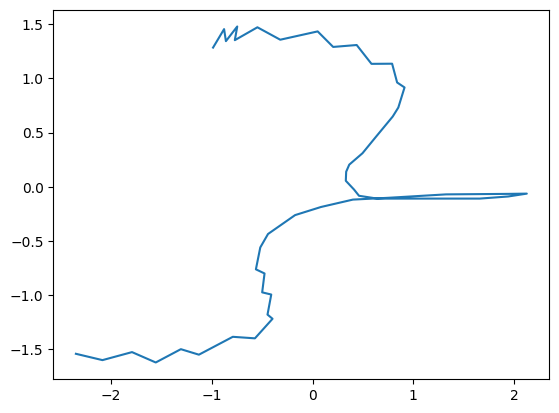

In [30]:
# look at data
test_data = random.sample(test, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)
print(label)

Prepare the data

In [31]:
train_labels = [sample[0] for sample in train]
test_labels = [sample[0] for sample in test]
labels = [sample[0] for sample in train]

print(set(train_labels))

encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.fit_transform(train_labels)


y_train = to_categorical(train_labels_encoded)
y_test = to_categorical(test_labels_encoded)

train_sequences = [sample[1] for sample in train]
X_train = np.array(train_sequences)

test_sequences = [sample[1] for sample in train]
X_test = np.array(test_sequences)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#"x", sizes: 5088, 'y' sizes: 160

{'caret', 'left_sq_bracket', 'check', 'left_curly_brace', 'v', 'rectangle', 'delete_mark', 'circle', 'arrow', 'x', 'question_mark', 'star', 'right_sq_bracket', 'pigtail', 'right_curly_brace', 'triangle'}
(5088, 50, 2) (5088, 50, 2) (5088, 16) (5088, 16)


In [32]:
print(y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


<div class="alert alert-info"><b>MODEL:</b> LSTM classifier </div>

Try to systematically reduce the LSTM's parameter count (at least **3** versions)

<details open>
<summary> <b> Systematic Approach </b> </summary>

**Default**
- 64 neurons
- accuracy/loss dont get a lot better after Epoch 6
- first dense layer reduces params by over half
- adding a [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) Layer
  - with small amount of rate -> 0.2 

**Dropout**
- does not change the number of params, but slightly better acc + faster
  - not sure if it actually drops anything with 0.2
- use half the amount of neurons and see what happens

**Half**
- 32 neurons
- params down by more than half
- accuracy almost the same (a little worse)
- try another half (i.e. quarter of default) to see if it gets a lot or a little worse

**Quarter**
- 16 neurons
- params pretty low
- accuracy does go down noticably (still very good)
- good strategy probably to stay between *half* and *quarter*
  - acc diff between default and half is pretty negligible
  - acc diff betwen half and quarter not that negligible anymore
- try middle of *half* and *quarter*

**mid-half-quarter**
- 24 neurons
- param count closer to quarter than to half
- accuracy basically in the middle of half and quarter
- so a good compormise

</details>

In [33]:
default_neurons = 64
half_neurons = int(default_neurons / 2)
quarter_neurons = int(default_neurons / 4)
mid_h_q = int( half_neurons - ( quarter_neurons / 2) )

neurons = mid_h_q
neurons

24

In [34]:
# code from "lstm_demo.ipynb"
model = Sequential()

# add LSTM layer
# input shape is (length of an individual sample, dimensions of the sample)
# in our case: two dimensions, as we have X and Y coordinates

# new syntax
model.add(Input((NUM_POINTS, 2)))

model.add(LSTM(neurons))

# add dense layer to do machine learning magic
model.add(Dense(32, activation='relu'))

# here, you can add more layers and maybe a dropout for better performance
model.add(Dropout(0.2))

# softmax layer for classification
model.add(Dense(len(set(train_labels)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [35]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2621 - loss: 2.4028 - val_accuracy: 0.7445 - val_loss: 1.1978 - learning_rate: 0.0010
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7302 - loss: 0.9790 - val_accuracy: 0.9294 - val_loss: 0.3379 - learning_rate: 0.0010
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9050 - loss: 0.3818 - val_accuracy: 0.9695 - val_loss: 0.1478 - learning_rate: 0.0010
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9379 - loss: 0.2407 - val_accuracy: 0.9680 - val_loss: 0.1203 - learning_rate: 0.0010
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9544 - loss: 0.1771 - val_accuracy: 0.9888 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9749 - loss: 0.1275 - val_accuracy: 0.9914 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9800 - loss: 0.0989 - 

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24)             │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,762 (45.95 KB)

 Trainable params: 3,920 (15.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,842 (30.64 KB)

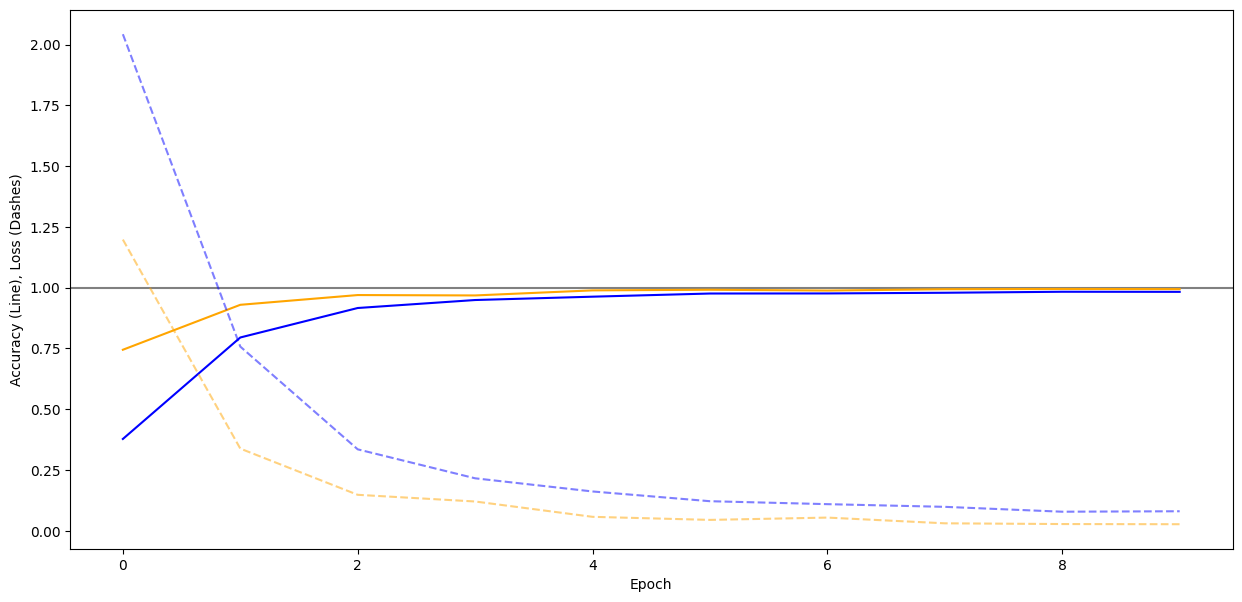

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
inference time = 0.5249083042144775 sec
0.9939072327044025


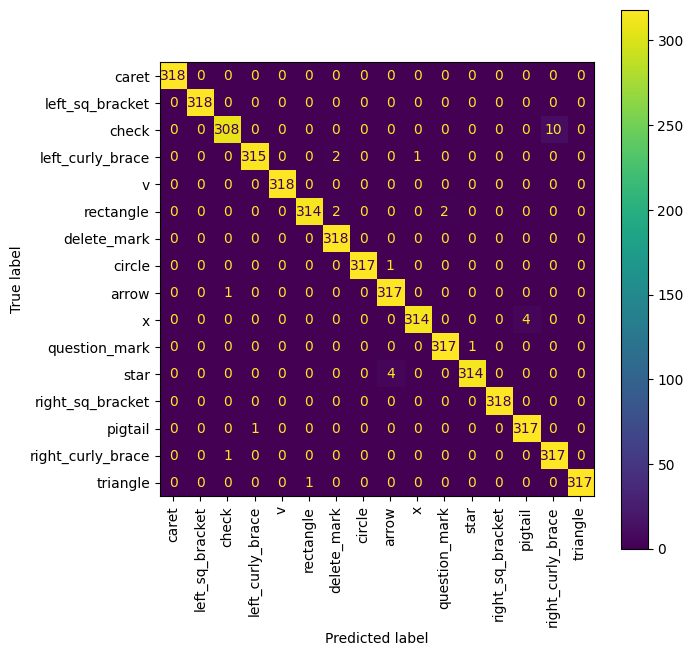

In [38]:
# let the model make predictions for our training data
start = time.time() # measure time
y_predictions = model.predict(X_test)
end = time.time()
inf_time = end - start
print("inference time =", inf_time, "sec") # time in seconds

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

acc_score = accuracy_score(y_test_labels, y_predictions)
print(acc_score)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(7, 7))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [43]:
# model.save('gesture-recognizer.keras')

Save logs

In [14]:
import pandas as pd
import json
import os

In [3]:
name = "mid-half-quarter"
notes_path = "logs/accs.csv"
history_path = f"logs/{name}-history.json"
conf_path = f"logs/{name}-conf.json"
summ_path = "logs/summaries.txt"

do_logging = False

In [4]:
if do_logging:
    # save general metrics in a table
    data = {"model": [name], "accuracy score": [acc_score], 
            "inference time": [inf_time], "trainable params": [model.count_params()],
            "neurons": [neurons]}
    # parameter counnt
    df = pd.DataFrame(data)
    df.to_csv(notes_path, mode="a", header=not os.path.exists(notes_path))

    # save the history as a json
    with open(history_path, 'w') as f:
        json.dump(history.history, f, indent=4)

    # save the confusion matrix as json
    with open(conf_path, 'w') as f:
        json.dump(conf_matrix.tolist(), f, indent=4)

    # save the summaries (see: https://stackoverflow.com/a/45546663)
    with open(summ_path, 'a', encoding="utf-8") as fh:
        fh.write(f"{name}\n")
        model.summary(print_fn=lambda x: fh.write(x + '\n'))
else:
    print("nothing to log")

nothing to log


**Comparison**

In [39]:
from recognizer import Recognizer, Parser
rec = Recognizer()

In [40]:
# compare to $1 gesture recognizer on acc and inference time

templates = Parser.parse_xml_files("dataset/templates")
ts = []
y_true = []
predictions = []

start = time.time() 

for gesture in test:
    label, points = gesture
    result, score = rec.recognize(points, templates)
    predictions.append(result) # predicted label
    y_true.append(label) # actual label

end = time.time()
d_inf_time = end - start

In [41]:
d_acc_score = accuracy_score(y_true, predictions)

print(len(y_true), y_true)
print(len(predictions), predictions)
print("inf time:", d_inf_time)
print("accuracy_score:", d_acc_score )

160 ['arrow', 'arrow-', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'caret', 'caret-', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'check', 'check-', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'circle', 'circle-', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'delete_mark', 'delete_mark-', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'left_curly_brace', 'left_curly_brace-', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_sq_brace', 'left_sq_brace-', 'left_sq_brace', 'left_sq_brace', 'left_sq_brace', 'left_sq_brace', 'left_sq_brace', 'left_sq_brace', 'left_sq_brace', 'left_sq_brace', 'pigtail', 'pigtail-', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail'

C:\Users\Leonie\AppData\Local\Temp\ipykernel_3484\1360272522.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


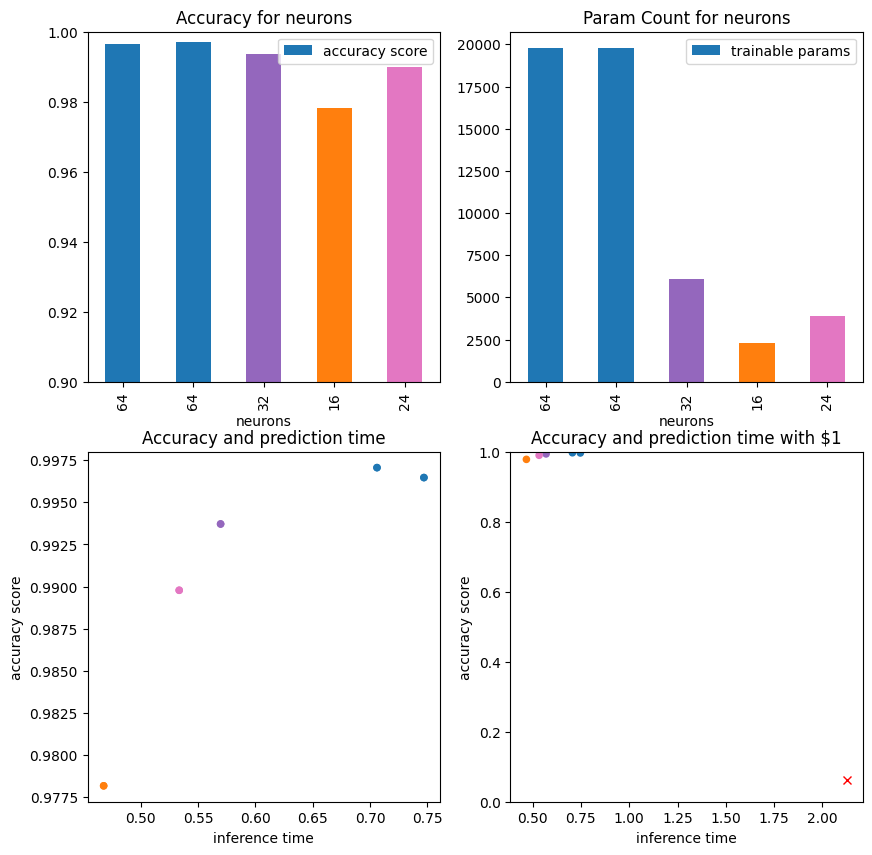

In [42]:
df = pd.read_csv("logs/accs.csv")
colors = ["tab:blue", "tab:blue", "tab:purple", "tab:orange", "tab:pink"]

fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title("Accuracy for neurons")

df.plot(x="neurons", y="accuracy score", kind="bar", ylim=(0.9,1.0), ax=plt.gca(), color=colors)
plt.subplot(2, 2, 2)
plt.title("Param Count for neurons")
df.plot(x="neurons", y="trainable params", kind="bar", ax=plt.gca(), color=colors)
plt.subplot(2, 2, 3)
plt.title("Accuracy and prediction time")
df.plot(x="inference time", y="accuracy score", kind="scatter", ax=plt.gca(), color=colors)
plt.subplot(2, 2, 3)
plt.title("Accuracy and prediction time")
df.plot(x="inference time", y="accuracy score", kind="scatter", ax=plt.gca(), color=colors)

# + $1 = red x
plt.subplot(2, 2, 4)
plt.title("Accuracy and prediction time with $1")
p = df.plot(x="inference time", y="accuracy score", kind="scatter", ylim=(0,1.0), ax=plt.gca(), color=colors)
p.plot(d_inf_time, d_acc_score, "xr")

fig.show()

# Report

#### **LSTM**
- reducing neuron reduces parameter count + prediction time
- systematic test with halfing neurons
  - then checking if the acc got worse by a noticeable amount
  - finding the upper and lower boundary with bigger steps, then checking for details
- finding neuron count, that is a compromise between low param count and high acc
- training itself was pretty similar, or at least unnoticably different

#### **Comparison**

**LSTM**
- fast if a dataset exists and pc is okay
  - collecting dataset can be a hassle (for this it's pretty okay)
- finding the right parameter count is fine
- good if model works quickly (Optimizing/Debugging a model isn't fun)
- model is pretty fast and reliable
- very obscured

**$1**
- if the alogrithm works it's mostly reliable (and quick enough for normal/small number of detections)
- has some constraints, like having to start at the same points
- feels smart, like you're actually contributed something
- don't have to deal with data collection

**Choice**
- Probably depends on the application and the setting
- Model:
  - If the dataset exists + model seems easy enough to set up (like right now)
  - If you need something robust for a lot of cases
  - If a pretrained model already exists for your problem
- Algorithm:
  - If no data exists, I would usually try an algorithm first
    - less initial setup involved
    - you can see if/how it works while your working on it (don't need to collect data and then realize that the model you made is bad or doesn't detect right in actual use)
  - If the application only requires easy/small-scale recognition

see: `logs/summaries.txt` for the model.summaries()